# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек 

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

import warnings
warnings.filterwarnings('ignore')


<a id="H0"></a>

##Тестирование гипотез

###Гипотеза для коэффициента корелляции

Коэффициент корреляции Пирсона рассчитывается по следующей формуле:
$r = \frac{\sum_i{(x_i - m_x)(y_i - m_y)}}{\sqrt{\sum_i{(x_i - m_x)^2\sum_i(y_i - m_y)^2}}}$

где $m_x$ - выборочное среднее для выборки x, $m_y$ - выборочное среднее для выборки y.

Подробнее: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [134]:
from scipy.stats import pearsonr

data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]

data2 = [0.353, 3.517, 0.125, -7.545, -0.555, -1.536, 3.350, -1.578, -3.537, -1.579]

stat, p = pearsonr(data1, data2)

print('stat=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Groups are different (reject H0)')
else:
    print('Groups are similar (fail to reject H0)')

stat=0.688, p=0.028
Groups are different (reject H0)


#Поработаем с датасетом c покупками

Метрики
ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.



#Подготовка данных

In [187]:
#Подгружаем данные с гугл диска
#from google.colab import drive
#drive.mount('/content/drive')


#data = pd.read_csv('/content/drive/MyDrive/data/ab_stats.csv')
data = pd.read_csv('ab_stats.csv')

data.head(10)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [189]:
data['ab_group'].value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [190]:
(data['ab_group'].value_counts()[0] - data['ab_group'].value_counts()[1])/(data['ab_group'].value_counts()[0] + data['ab_group'].value_counts()[1])/2

0.000380517503805175

In [191]:
data.shape

(23652, 5)

In [192]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [193]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [194]:
data.ab_group.value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [195]:
len(data[data['revenue']>0])

490

In [197]:
len(data)

23652

In [198]:
data_new = data[data['revenue']>0]

Посмотрим на группы отдельно

In [199]:
data['ab_group']=='A'

0         True
1         True
2         True
3         True
4         True
         ...  
23647    False
23648    False
23649    False
23650    False
23651    False
Name: ab_group, Length: 23652, dtype: bool

In [200]:
data[data['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11835.000000,11835.000000,11835.000000,11835.000000
mean,0.404462,0.050697,0.021631,6.974724
std,13.133218,1.467511,0.145481,2.023533
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.656155
50%,0.000000,0.000000,0.000000,6.982329
75%,0.000000,0.000000,0.000000,8.345572
max,1303.609284,152.000000,1.000000,17.728836


In [201]:
data[data['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11817.000000,11817.000000,11817.000000,11817.000000
mean,0.244794,0.036473,0.019802,7.051559
std,3.176534,0.418480,0.139325,3.976799
min,0.000000,0.000000,0.000000,-8.286822
25%,0.000000,0.000000,0.000000,4.380984
50%,0.000000,0.000000,0.000000,7.060873
75%,0.000000,0.000000,0.000000,9.768648
max,113.830000,25.000000,1.000000,22.446822


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

#Проверка на нормальность распределения и применение статистических критериев

##Метрика визиты на юзера

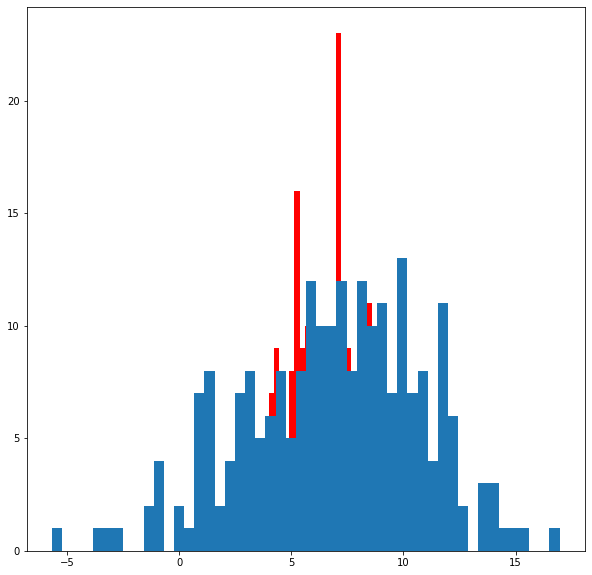

In [148]:
plt.figure(figsize=(10, 10))
control_visit_all = data['av_site visit'][data['ab_group'] == 'A']
test_visit_all =data['av_site visit'][data['ab_group'] == 'B']


plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)


plt.show()

In [202]:
scipy.stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=-0.3170173528529596, pvalue=0.7514242909453878)

##Метрика доля юзеров с покупкой

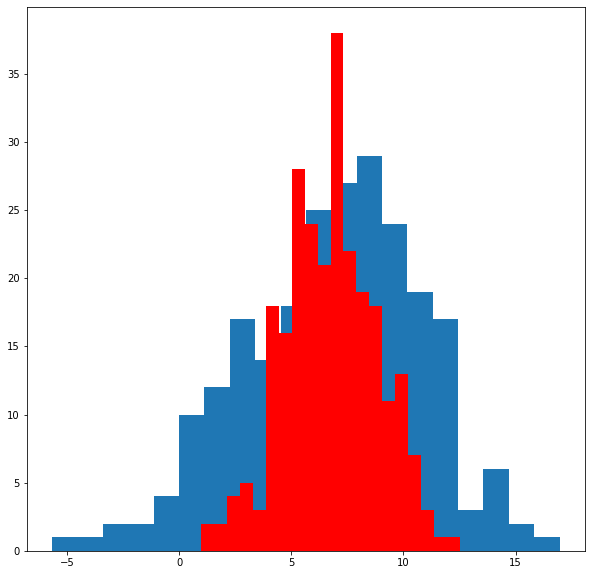

In [203]:
plt.figure(figsize=(10, 10))
control_visit = data['av_site visit'][(data['ab_group'] == 'A')&(data['purchase'] == 1)]
test_visit =data['av_site visit'][(data['ab_group'] == 'B')&(data['purchase'] == 1)]
plt.hist(test_visit,  bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [204]:
data['purchase'].value_counts()

0    23162
1      490
Name: purchase, dtype: int64

In [207]:
k1 = data[data['ab_group']=='A']['purchase'].sum()
k2 = data[data['ab_group']=='B']['purchase'].sum()

In [210]:
k1 + k2

490

In [211]:
k1

256

In [209]:
data[data['ab_group']=='A'].shape[0]

11835

In [206]:
n1 = data[data['ab_group']=='A'].shape[0]
n2 = data[data['ab_group']=='B'].shape[0]

In [212]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

Results are  z_score =0.987, pvalue = 0.323


In [213]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


Непараметрический Хи-квадрат

In [214]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

Results are  chisq =0.975, pvalue = 0.323


In [215]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We have failed to reject the null hypothesis


#Метрика arpu


 Непараметрический критерий  Манн-Уитни

In [216]:
data.groupby('ab_group')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ab_group,,,,,,,,
A,11835.0,0.404462,13.133218,0.0,0.0,0.0,0.0,1303.609284
B,11817.0,0.244794,3.176534,0.0,0.0,0.0,0.0,113.830000


In [219]:
data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values

array([1.88559500e+00, 1.00215900e+00, 2.99000000e+00, 4.99900000e+01,
       2.20937570e+01, 2.77365000e+00, 8.71962400e+00, 1.12200200e+01,
       1.99900000e+01, 3.93152700e+00, 2.99800000e+01, 3.71941500e+00,
       2.48831200e+00, 2.44408400e+00, 6.02497750e+01, 4.99000000e+00,
       9.67350000e-01, 2.69942740e+01, 6.97743700e+00, 9.99000000e+00,
       4.99000000e+00, 1.45288500e+00, 9.99000000e+01, 3.78745800e+00,
       5.96000000e+00, 1.23158640e+01, 1.83413100e+00, 6.14381500e+00,
       1.99000000e+00, 1.99000000e+00, 2.48099500e+00, 1.47267450e+01,
       6.07975700e+00, 1.47141800e+00, 3.91444700e+00, 4.91041260e+01,
       1.58409900e+00, 1.99000000e+00, 1.02924110e+01, 4.28244000e+00,
       2.33864000e+00, 9.88025000e-01, 2.67944700e+00, 1.97270000e+00,
       8.49400020e+01, 2.38778100e+00, 1.03155770e+01, 2.36921150e+01,
       8.26226800e+00, 2.44750200e+00, 1.99000000e+00, 1.19800000e+01,
       4.99000000e+00, 2.59689000e-01, 2.50076000e+00, 2.13062300e+00,
      

In [220]:
mw_stats = scipy.stats.mannwhitneyu(x=data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'].values)
mw_stats

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

##Рассмотрим кейс с рекламной выручкой

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./test.xlsx');

In [222]:
df = pd.read_excel('test.xlsx')

In [223]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [227]:
df['USER_ID'] = df['USER_ID'].astype('str')
df['VARIANT_NAME'] = df['VARIANT_NAME'].astype('str')

In [228]:
df.describe()

,REVENUE
count,10000.000000
mean,0.099447
std,2.318529
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [230]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [232]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [235]:
(df.VARIANT_NAME.value_counts()[0] - df.VARIANT_NAME.value_counts()[1])/(df.VARIANT_NAME.value_counts()[0] + df.VARIANT_NAME.value_counts()[1])/2

0.0016

In [236]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

variants = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [237]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,10,2
1,1000,1
2,10000,2
3,1002,1
4,1003,1
5,1004,1
6,1005,1
7,1007,1
8,1009,2
9,1010,2


In [239]:
more_than_one_types = variants.query('VARIANT_NAME > 1')

In [241]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')
df_new 

,USER_ID,VARIANT_NAME,REVENUE
9892,1000,control,0.0
6263,1000,control,0.0
8030,1002,control,0.0
7939,1003,control,0.0
6587,1004,variant,0.0
...,...,...,...
3260,9992,control,0.0
9290,9993,control,0.0
2749,9995,variant,0.0
5673,9995,variant,0.0


In [242]:
df_new.shape

(6070, 3)

In [243]:
df.shape

(10000, 3)

In [245]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [246]:
len(control)

3026

In [247]:
len(test)

3044

In [248]:
from scipy.stats import shapiro

In [250]:
alpha = 0.05

st = shapiro(df_new.REVENUE)
st

ShapiroResult(statistic=0.015946388244628906, pvalue=0.0)

In [251]:
print('Distribution is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]));

Distribution is not normal



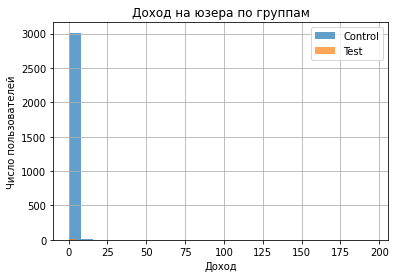

In [256]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

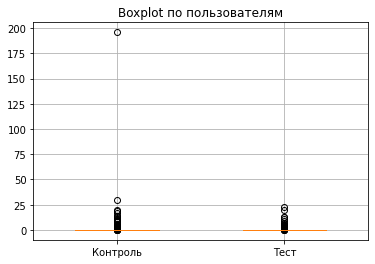

In [257]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [265]:
control.REVENUE

9892    0.0
6263    0.0
8030    0.0
7939    0.0
4874    0.0
       ... 
1755    0.0
1848    0.0
3260    0.0
9290    0.0
1064    0.0
Name: REVENUE, Length: 3026, dtype: float64

In [258]:
scipy.stats.stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.4037622523716748, pvalue=0.16048440176908432)

In [261]:
control[control['REVENUE'] > 0];

In [264]:
test[test['REVENUE'] > 0];

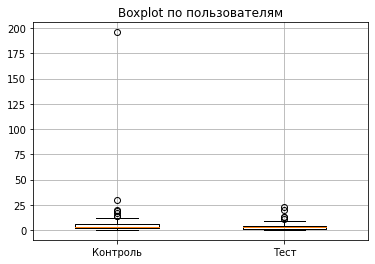

In [268]:
plt.boxplot([control[control['REVENUE'] > 0].REVENUE,test[test['REVENUE'] > 0].REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5)
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

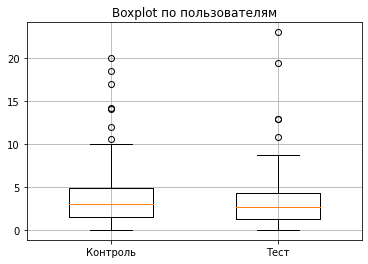

In [269]:
plt.boxplot([control[(control['REVENUE'] > 0) & (control['REVENUE'] < 25)].REVENUE,test[(test['REVENUE'] > 0) & (test['REVENUE'] < 25)].REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5)
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

##Расчет мощности


d = (M1 – M2) / S_pooled






## S_pooled =

  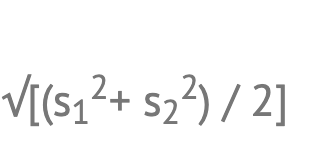

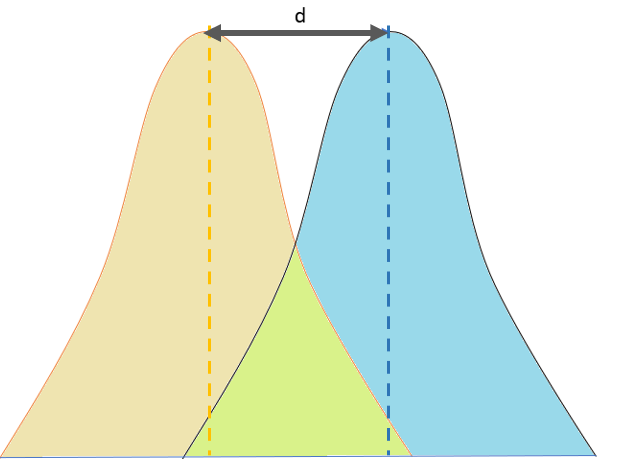

[Про коэффициент Кохена(Cohen's d)](https://www.statology.org/interpret-cohens-d/)

In [271]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [272]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

3026 3044


In [273]:
n =  len(control.REVENUE.values)

In [184]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [185]:
effect =float((T_mean-C_mean)/ S) 

In [276]:
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result

0.16707722512308862